# Music Genre Classification - Audio Data Classification Modeling

## Contents
- [Imports](#Imports)
- [Data](#Load-Data)
- [Modeling](#Modeling)
    - [Dense Neural Network (DNN)](#Dense-Neural-Network-(DNN))
    - [Convolutional Neural Network (Without Regularization)](#Convolutional-Neural-Network-(Without-Regularization))
    - [Convolutional Neural Network (With Regularization)](#Convolutional-Neural-Network-(With-Regularization))
- [Save Model](#Save-Model)
- [Make Predictions](#Make-Predictions)
- [Conclusions & Recommendations](#Conclusions-\&-Recommendations)

### Imports

In [3]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import librosa

# Sklean
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# TensorFlow
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Load Data
- Load in the MFCCs and genre classifications.
- View a sample of the MFCCs to ensure data was imported properly.

In [9]:
# Load in audio data
filepath = r'D:/Music-Genre-Classification-Using-Convolutional-Neural-Networks-main/Music-Genre-Classification-Using-Convolutional-Neural-Networks-main/data/data.json'
with open(filepath, "r") as fp:
    data = json.load(fp)

In [10]:
def plot_mfcc(mfcc, fs, fig_size=(12,6)):
    """Plots the mel-scaled spectrogram from mfccs. This is performing the same task as
    'plot_mel_spectrogram_audio' with just a different input.
    
    Parameters:
        mfcc (numpy.ndarray): mfccs of an audio signal
        fs (int): sampling frequency (Hz) of audio signal
        fig_size (tuple): Dimensions of figure
    """
    # Plot Spectrogram
    plt.figure(figsize=fig_size)
    
    # Display the spectrogram on a mel scale
    # sample rate and hop length parameters are used to render the time axis
    # abs on signal for better visualization
    librosa.display.specshow(data=mfcc, sr=fs, x_axis='time', y_axis='linear', cmap='viridis')
    
    # Put a descriptive title on the plot
    plt.title('MFCCs')

    # draw a color bar
    plt.colorbar(format='%+02.0f dB')

    # Make the figure layout compact
    plt.tight_layout()

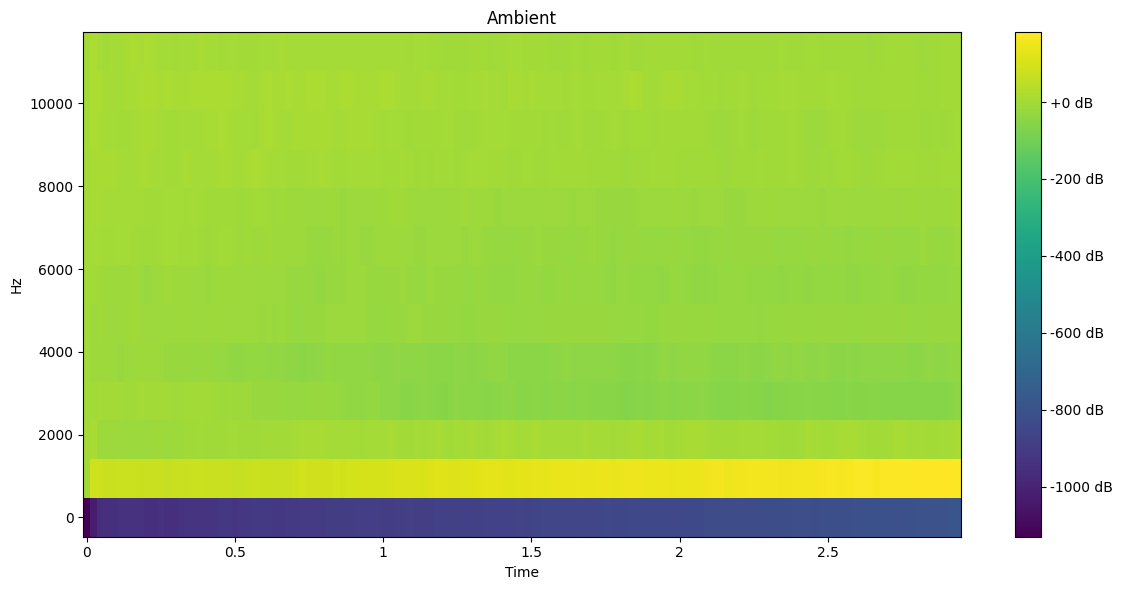

In [11]:
# Plot MFCC example to ensure data was imported properly
# Dataset has ~910 samples (91 audio files x 10 segments)
idx = 100  # Use index within range
fs = 22500
plot_mfcc(np.array(data["mfcc"])[idx].T, fs)
plt.title(f"{np.array(data['genre_name'])[idx].title()}");

## Modeling
- Two types of models were tested
    - Dense Neural Network (DNN)
    - Convolutional Neural Network (CNN)
- For audio and image classification, CNNs typically outperform DNNs. Our testing confirmed this, so we worked with the CNN to improve its performance through parameter tuning and regularization techniques.
- Additionally, data needs to be in the correct "shape" in order to input into certain models.
    - DNN: (n, n)
    - CNN: (n, n, 1)
- Data is also split into 3 sets
    - Training set: For the model to train on
    - Validation set: For the model to compare against while training
    - Test set: A set unsees by the model until the end for final testing

In [12]:
# Define X nd y
X = np.array(data["mfcc"])
y = np.array(data["genre_num"])

In [13]:
# Train-validation-test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

# shape = (# samples, time-bins (x), num MFCCs (y))
print(f"X training data shape: {X_train.shape}, y training data shape: {y_train.shape}")
print(f"X validation data shape: {X_val.shape}, y validation data shape: {y_val.shape}")

X training data shape: (445, 130, 13), y training data shape: (445,)
X validation data shape: (192, 130, 13), y validation data shape: (192,)


In [14]:
def plot_history(hist):
    """Plots the accuracy and loss for a model over the course of all epochs
    
    Parameters:
        hist (keras history object): The recorded history of model.fit() to be plotted
    """
    fig, axs = plt.subplots(2, 1, figsize=(8,7))
    fig.tight_layout(pad=2)
    
    # Accuracy subplot
    axs[0].plot(hist.history["acc"], c='navy', label="Training Accuracy")
    axs[0].plot(hist.history["val_acc"], c='orange', label="Validation Accuracy")    
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy")
    
    # Error subplot
    axs[1].plot(hist.history["loss"], c='navy', label="Training Loss")
    axs[1].plot(hist.history["val_loss"], c='orange', label="Validation Loss")    
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epochs")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss")
    
    plt.show()

### Dense Neural Network (DNN)
- A Dense Neural Network consists of multiple dense layers ordered sequentially one after the other.
- An 'l2' regularization penalty was leveraged to help mitigate overfitting.
- Dropout layers were included to help mitigate overfitting.
- Dense neural networks are useful for some tasks, but often do not perform as well on image and audio data.

In [15]:
# Dense Neural Network

# Instantiate sequential model
model_dnn = Sequential()

# Flatten to dense
model_dnn.add(Flatten(input_shape=(X.shape[1:3])))

# Create Dense Layers
model_dnn.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
model_dnn.add(Dropout(0.3))
model_dnn.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model_dnn.add(Dropout(0.3))
model_dnn.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model_dnn.add(Dropout(0.3))
model_dnn.add(Dense(3, activation='softmax'))  # 3 classes: ambient, pop, rock

c:\Users\ADVAN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
# Review model structure
model_dnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 1690)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       865,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,013,763 (3.87 MB)

 Trainable params: 1,013,763 (3.87 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Compile
model_dnn.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy', # loss for multi-class classification
    metrics=['acc']
)

In [18]:
# Train the model
hist_dnn = model_dnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=64,
    epochs=250,
    verbose=1
)

Epoch 1/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - acc: 0.3708 - loss: 77.5093 - val_acc: 0.6354 - val_loss: 13.1307
Epoch 2/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - acc: 0.3708 - loss: 77.5093 - val_acc: 0.6354 - val_loss: 13.1307
Epoch 2/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - acc: 0.5326 - loss: 44.6528 - val_acc: 0.6562 - val_loss: 13.5370
Epoch 3/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - acc: 0.5326 - loss: 44.6528 - val_acc: 0.6562 - val_loss: 13.5370
Epoch 3/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - acc: 0.5303 - loss: 35.1467 - val_acc: 0.7552 - val_loss: 7.2337
Epoch 4/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - acc: 0.5303 - loss: 35.1467 - val_acc: 0.7552 - val_loss: 7.2337
Epoch 4/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - acc: 0.5865 - loss: 30.5956 - val_acc: 0.7188 - val_loss: 7.2041
Epoch 5/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - acc: 0.5865 - loss: 30.5956 - val_acc: 0.7188 - val_loss: 7.2041
Epoch 5/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - acc: 0.6

In [19]:
loss_dnn, acc_dnn = model_dnn.evaluate(X_test, y_test)
print(f"Test Loss: {loss_dnn}")
print(f"Test Accuracy: {acc_dnn}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.8645 - loss: 1.7257  
Test Loss: 1.7256718873977661
Test Accuracy: 0.8644688725471497
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.8645 - loss: 1.7257  
Test Loss: 1.7256718873977661
Test Accuracy: 0.8644688725471497


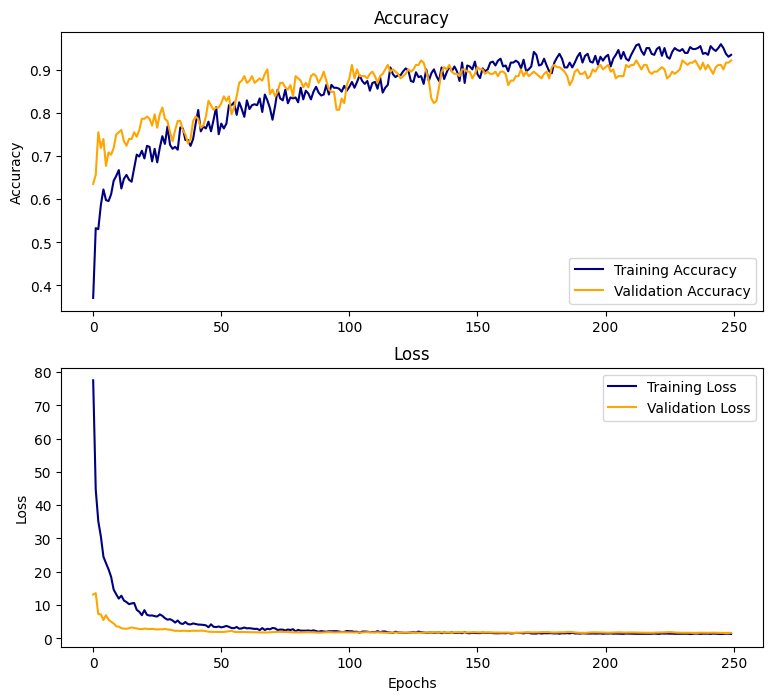

In [20]:
plot_history(hist_dnn)

### Convolutional Neural Network (Without Regularization)
- A Convolutional Neural Network (CNN) consists of a combination of convolution layers and dense layers.
- Convolution layers first begin to identify features within the data, similar to edge detection in image data.
- The the data is flattened out to run through dense layers to classify the data.
- A base CNN was tested without regulatization methods to establish a base performance before iterating through tuning parameters.

In [21]:
# Add additional dimension for CNN
X_train_cnn = X_train[..., np.newaxis]
X_val_cnn = X_val[..., np.newaxis]
X_test_cnn = X_test[..., np.newaxis]

input_shape = X_train_cnn.shape[1:4]
X_train_cnn.shape # shape = (# samples, time-bins (x), num MFCCs (y), "channel" (like an image))

(445, 130, 13, 1)

In [25]:
# Convolutional Neural Network - Original

# Instantiate sequential model
model_cnn1 = Sequential()

# Create a convolution block
model_cnn1.add(Conv2D(32, 3, activation='relu', input_shape=input_shape)) # first hidden conv layer
model_cnn1.add(MaxPooling2D(3, strides=(2,2), padding='same')) # MaxPool the results

# Add another conv block
model_cnn1.add(Conv2D(64, 3, activation='relu'))
model_cnn1.add(MaxPooling2D(3, strides=(2,2), padding='same'))

# Add another conv block
model_cnn1.add(Conv2D(64, 2, activation='relu'))
model_cnn1.add(MaxPooling2D(2, strides=(2,2), padding='same'))

# Flatten output to send through dense layers
model_cnn1.add(Flatten())
model_cnn1.add(Dense(64, activation='relu'))

# output to 3 classes for predictions
model_cnn1.add(Dense(3, activation='softmax'))  # 3 classes: ambient, pop, rock

In [26]:
model_cnn1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 11, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 62, 4, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 31, 2, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 30, 1, 64)      │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 15, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        61,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,963 (378.76 KB)

 Trainable params: 96,963 (378.76 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
model_cnn1.compile(
    optimizer=Adam(learning_rate=0.0001), # can also use 'adam'
    loss='sparse_categorical_crossentropy', # loss for multi-class classification
    metrics=['acc']
)

In [28]:
%%time
# Train the model
hist_cnn1 = model_cnn1.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    batch_size=64,
    epochs=250,
    verbose=1
)

Epoch 1/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - acc: 0.4584 - loss: 2.2523 - val_acc: 0.6562 - val_loss: 1.1694
Epoch 2/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - acc: 0.4584 - loss: 2.2523 - val_acc: 0.6562 - val_loss: 1.1694
Epoch 2/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - acc: 0.6607 - loss: 1.0254 - val_acc: 0.7396 - val_loss: 0.7931
Epoch 3/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - acc: 0.6607 - loss: 1.0254 - val_acc: 0.7396 - val_loss: 0.7931
Epoch 3/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - acc: 0.7775 - loss: 0.6993 - val_acc: 0.7708 - val_loss: 0.6657
Epoch 4/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - acc: 0.7775 - loss: 0.6993 - val_acc: 0.7708 - val_loss: 0.6657
Epoch 4/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - acc: 0.7978 - loss: 0.5627 - val_acc: 0.8177 - val_loss: 0.5428
Epoch 5/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - acc: 0.7978 - loss: 0.5627 - val_acc: 0.8177 - val_loss: 0.5428
Epoch 5/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - acc: 0.8404 - loss: 

In [29]:
loss_cnn1, acc_cnn1 = model_cnn1.evaluate(X_test_cnn, y_test)
print(f"Test Loss: {loss_cnn1}")
print(f"Test Accuracy: {acc_cnn1}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.9011 - loss: 0.3439
Test Loss: 0.3439389765262604
Test Accuracy: 0.901098906993866
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.9011 - loss: 0.3439
Test Loss: 0.3439389765262604
Test Accuracy: 0.901098906993866


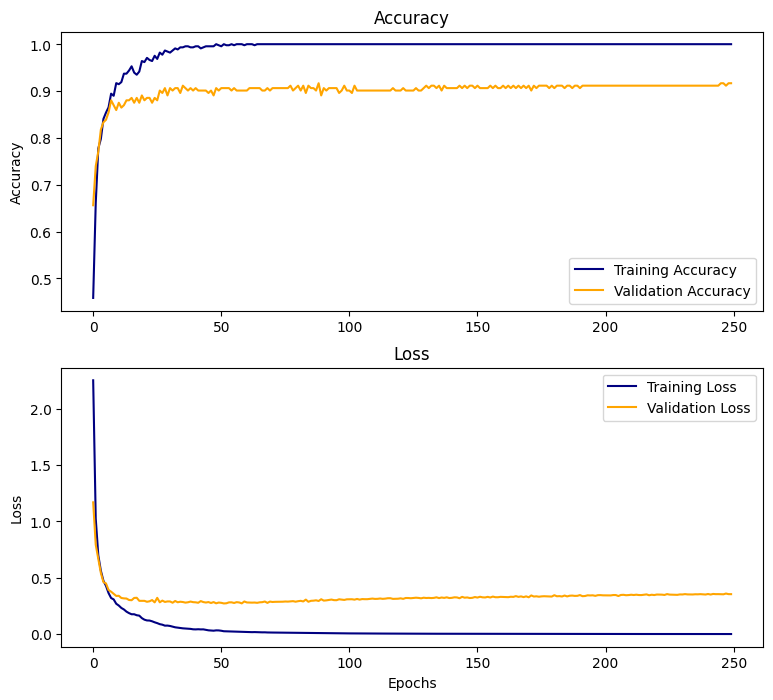

In [30]:
plot_history(hist_cnn1)

### Convolutional Neural Network (With Regularization)
- A Convolutional Neural Network (CNN) consists of a combination of convolution layers and dense layers.
- Convolution layers first begin to identify features within the data, similar to edge detection in image data.
- The the data is flattened out to run through dense layers to classify the data.
- The CNN below went through many iterations to tune regularization parameters. We included:
    - Dropout: Drops some nodes through each epoch to force all nodes to learn all features of the model. This helps reduce overfitting of the model.
    - Early Stopping: This stops the model once it has reached a certain threshold of no longer improving. This also helps reduce overfitting.
    - Regularization penalties (such as 'l2') were *not* leveraged for the CNN, as they do not improve the performance of the model.

In [31]:
# Convolutional Neural Network - BEST

# Instantiate sequential model
model_cnn2 = Sequential()

# Create a convolution block
model_cnn2.add(Conv2D(32, 3, activation='relu', input_shape=input_shape)) # first hidden conv layer
model_cnn2.add(BatchNormalization())
model_cnn2.add(MaxPooling2D(3, strides=(2,2), padding='same')) # MaxPool the results
model_cnn2.add(Dropout(0.2))

# Add another conv block
model_cnn2.add(Conv2D(64, 3, activation='relu'))
model_cnn2.add(BatchNormalization())
model_cnn2.add(MaxPooling2D(3, strides=(2,2), padding='same'))
model_cnn2.add(Dropout(0.1))

# Add another conv block
model_cnn2.add(Conv2D(64, 2, activation='relu'))
model_cnn2.add(BatchNormalization())
model_cnn2.add(MaxPooling2D(2, strides=(2,2), padding='same'))
model_cnn2.add(Dropout(0.1))

# Flatten output to send through dense layers
model_cnn2.add(Flatten())
model_cnn2.add(Dense(128, activation='relu'))
model_cnn2.add(Dropout(0.5))

# output to 3 classes for predictions
model_cnn2.add(Dense(3, activation='softmax'))  # 3 classes: ambient, pop, rock

In [32]:
model_cnn2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 128, 11, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 11, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 62, 4, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 62, 4, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 31, 2, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 31, 2, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 30, 1, 64)      │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 30, 1, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 15, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 15, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       123,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,299 (622.26 KB)

 Trainable params: 158,979 (621.01 KB)

 Non-trainable params: 320 (1.25 KB)

In [33]:
model_cnn2.compile(
    optimizer=Adam(learning_rate=0.0001), # can also use 'adam'
    loss='sparse_categorical_crossentropy', # loss for multi-class classification
    metrics=['acc']
)

In [34]:
# Create an early stopping callback
es_cnn2 = EarlyStopping(monitor='val_loss', patience=20, min_delta=0) 

In [35]:
%%time
# Train the model
hist_cnn2 = model_cnn2.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    batch_size=64,
    epochs=250,
    verbose=1
#     callbacks=[es_cnn2]
)

Epoch 1/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step - acc: 0.3910 - loss: 2.0189 - val_acc: 0.3333 - val_loss: 3.3077
Epoch 2/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step - acc: 0.3910 - loss: 2.0189 - val_acc: 0.3333 - val_loss: 3.3077
Epoch 2/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - acc: 0.4472 - loss: 1.6576 - val_acc: 0.3594 - val_loss: 2.1076
Epoch 3/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - acc: 0.4472 - loss: 1.6576 - val_acc: 0.3594 - val_loss: 2.1076
Epoch 3/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - acc: 0.5663 - loss: 1.2877 - val_acc: 0.3958 - val_loss: 1.5382
Epoch 4/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - acc: 0.5663 - loss: 1.2877 - val_acc: 0.3958 - val_loss: 1.5382
Epoch 4/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - acc: 0.5865 - loss: 1.0621 - val_acc: 0.4531 - val_loss: 1.2150
Epoch 5/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - acc: 0.5865 - loss: 1.0621 - val_acc: 0.4531 - val_loss: 1.2150
Epoch 5/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - acc: 0.6315 - los

In [36]:
loss_cnn2, acc_cnn2 = model_cnn2.evaluate(X_test_cnn, y_test)
print(f"Test Loss: {loss_cnn2}")
print(f"Test Accuracy: {acc_cnn2}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.8901 - loss: 0.4159
Test Loss: 0.4159170687198639
Test Accuracy: 0.8901098966598511
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.8901 - loss: 0.4159
Test Loss: 0.4159170687198639
Test Accuracy: 0.8901098966598511


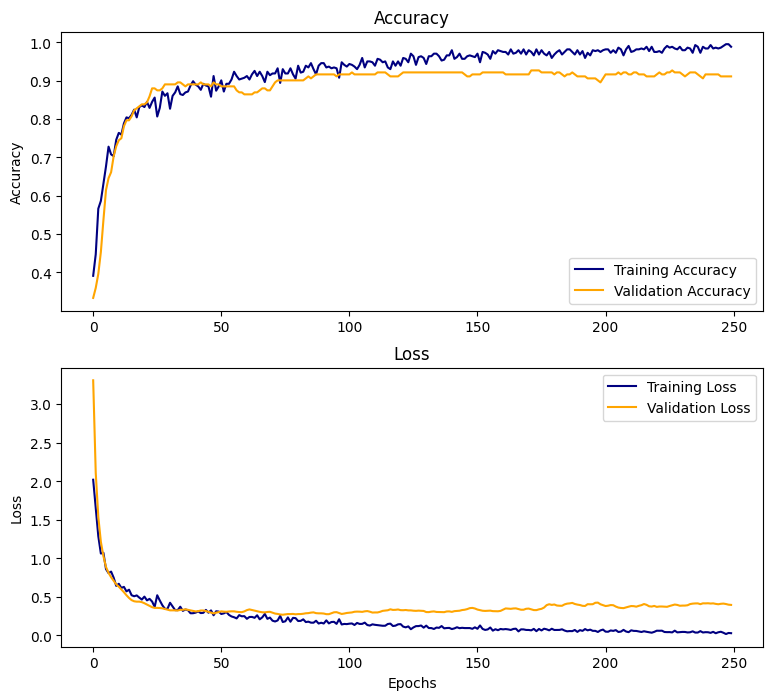

In [37]:
plot_history(hist_cnn2)

### Convolutional Neural Network (With Regularization and Data Augmentation)
- This model is exactly the same as the previous CNN with regularization techniques implemented, with an addition of a data augmentation technique.
- Because the audio data has essentially been transcoded into something similar to an image, flipping the "image" can effectively add more diverse data for the model to train on. This flipping is analogous to feeding the audio clip through the model in reverse.
- Adding this diversity in data can improve the model without having to truly provide it more data.

In [38]:
# Convolutional Neural Network - BEST

# Instantiate sequential model
model_cnn3 = Sequential()

# Create a convolution block
model_cnn3.add(Conv2D(32, 3, activation='relu', input_shape=input_shape)) # first hidden conv layer
model_cnn3.add(BatchNormalization())
model_cnn3.add(MaxPooling2D(3, strides=(2,2), padding='same')) # MaxPool the results
model_cnn3.add(Dropout(0.2))

# Add another conv block
model_cnn3.add(Conv2D(64, 3, activation='relu'))
model_cnn3.add(BatchNormalization())
model_cnn3.add(MaxPooling2D(3, strides=(2,2), padding='same'))
model_cnn3.add(Dropout(0.1))

# Add another conv block
model_cnn3.add(Conv2D(64, 2, activation='relu'))
model_cnn3.add(BatchNormalization())
model_cnn3.add(MaxPooling2D(2, strides=(2,2), padding='same'))
model_cnn3.add(Dropout(0.1))

# Flatten output to send through dense layers
model_cnn3.add(Flatten())
model_cnn3.add(Dense(128, activation='relu'))
model_cnn3.add(Dropout(0.5))

# output to 3 classes for predictions
model_cnn3.add(Dense(3, activation='softmax'))  # 3 classes: ambient, pop, rock

In [39]:
model_cnn3.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 128, 11, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 11, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 64, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 62, 4, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 62, 4, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 31, 2, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 31, 2, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 30, 1, 64)      │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 30, 1, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 15, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 15, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       123,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,299 (622.26 KB)

 Trainable params: 158,979 (621.01 KB)

 Non-trainable params: 320 (1.25 KB)

In [40]:
model_cnn3.compile(
    optimizer=Adam(learning_rate=0.0001), # can also use 'adam'
    loss='sparse_categorical_crossentropy', # loss for multi-class classification
    metrics=['acc']
)

In [41]:
# Datagen
datagen = ImageDataGenerator(vertical_flip=True)

In [42]:
# Create an early stopping callback
es_cnn3 = EarlyStopping(monitor='val_loss', patience=20, min_delta=0) 

In [43]:
%%time
# Train the model
hist_cnn3 = model_cnn3.fit(
    datagen.flow(X_train_cnn, y_train),
    validation_data=(X_val_cnn, y_val),
    batch_size=64,
    epochs=400,
    verbose=1
#     callbacks=[es_cnn]
)

Epoch 1/400
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - acc: 0.3955 - loss: 1.9695 - val_acc: 0.3385 - val_loss: 2.1279
Epoch 2/400
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - acc: 0.3955 - loss: 1.9695 - val_acc: 0.3385 - val_loss: 2.1279
Epoch 2/400
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - acc: 0.4966 - loss: 1.6167 - val_acc: 0.3281 - val_loss: 1.9835
Epoch 3/400
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - acc: 0.4966 - loss: 1.6167 - val_acc: 0.3281 - val_loss: 1.9835
Epoch 3/400
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - acc: 0.5326 - loss: 1.3795 - val_acc: 0.3385 - val_loss: 1.6265
Epoch 4/400
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - acc: 0.5326 - loss: 1.3795 - val_acc: 0.3385 - val_loss: 1.6265
Epoch 4/400
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - acc: 0.6022 - loss: 1.1917 - val_acc: 0.4062 - val_loss: 1.2360
Epoch 5/400
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - acc: 0.6022 - loss: 1.1917 - val_acc: 0.4062 - val_loss: 1.2360
Epoch 5/400
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - ac

In [44]:
loss_cnn3, acc_cnn3 = model_cnn3.evaluate(X_test_cnn, y_test)
print(f"Test Loss: {loss_cnn3}")
print(f"Test Accuracy: {acc_cnn3}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.8462 - loss: 0.8825
Test Loss: 0.8824533224105835
Test Accuracy: 0.8461538553237915
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.8462 - loss: 0.8825
Test Loss: 0.8824533224105835
Test Accuracy: 0.8461538553237915


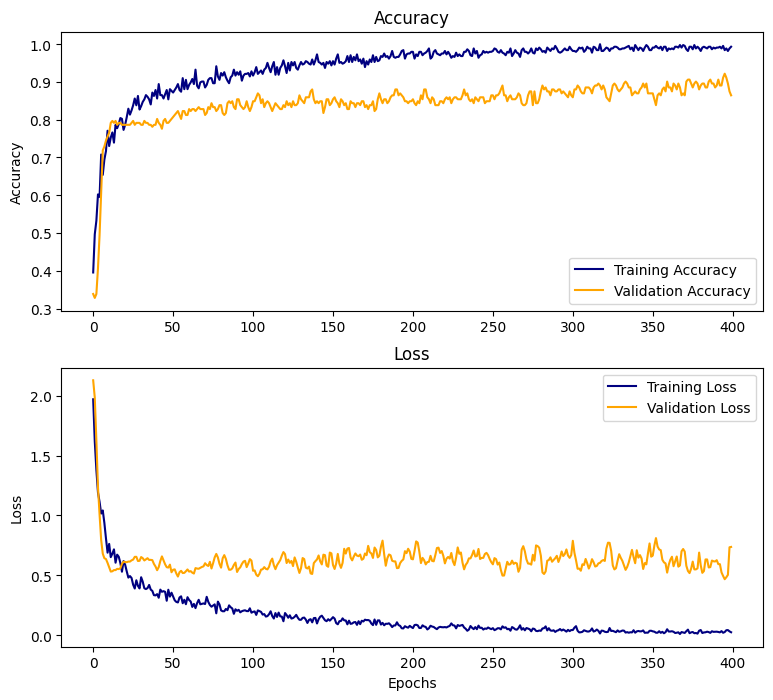

In [45]:
plot_history(hist_cnn3)

### Save Models
- Save the model to disk to allow for later predictions

In [46]:
# Save models to disk with absolute path
model_path = r'D:/Music-Genre-Classification-Using-Convolutional-Neural-Networks-main/Music-Genre-Classification-Using-Convolutional-Neural-Networks-main/models/'

print("Saving models...")
model_dnn.save(model_path + 'model_dnn.h5')
print(f"✓ DNN model saved to {model_path}model_dnn.h5")

model_cnn1.save(model_path + 'model_cnn1.h5')
print(f"✓ CNN-1 model saved to {model_path}model_cnn1.h5")

model_cnn2.save(model_path + 'model_cnn2.h5')
print(f"✓ CNN-2 model saved to {model_path}model_cnn2.h5")

model_cnn3.save(model_path + 'model_cnn3.h5')
print(f"✓ CNN-3 model saved to {model_path}model_cnn3.h5")

print("\nAll models saved successfully!")

Saving models...


✓ DNN model saved to D:/Music-Genre-Classification-Using-Convolutional-Neural-Networks-main/Music-Genre-Classification-Using-Convolutional-Neural-Networks-main/models/model_dnn.h5
✓ CNN-1 model saved to D:/Music-Genre-Classification-Using-Convolutional-Neural-Networks-main/Music-Genre-Classification-Using-Convolutional-Neural-Networks-main/models/model_cnn1.h5


✓ CNN-2 model saved to D:/Music-Genre-Classification-Using-Convolutional-Neural-Networks-main/Music-Genre-Classification-Using-Convolutional-Neural-Networks-main/models/model_cnn2.h5
✓ CNN-3 model saved to D:/Music-Genre-Classification-Using-Convolutional-Neural-Networks-main/Music-Genre-Classification-Using-Convolutional-Neural-Networks-main/models/model_cnn3.h5

All models saved successfully!


In [5]:
# Verify saved models
import os
model_path = r'D:/Music-Genre-Classification-Using-Convolutional-Neural-Networks-main/Music-Genre-Classification-Using-Convolutional-Neural-Networks-main/models/'

print("\nChecking saved models in folder:")
print(f"{model_path}\n")

if os.path.exists(model_path):
    saved_models = [f for f in os.listdir(model_path) if f.endswith('.h5')]
    if saved_models:
        print(f"Found {len(saved_models)} saved model(s):")
        for model_file in saved_models:
            file_path = os.path.join(model_path, model_file)
            file_size = os.path.getsize(file_path) / (1024 * 1024)  # Convert to MB
            print(f"  ✓ {model_file} ({file_size:.2f} MB)")
    else:
        print("⚠ No .h5 model files found. Please run the save models cell above.")
else:
    print(f"⚠ Models folder not found at: {model_path}")


Checking saved models in folder:
D:/Music-Genre-Classification-Using-Convolutional-Neural-Networks-main/Music-Genre-Classification-Using-Convolutional-Neural-Networks-main/models/

Found 4 saved model(s):
  ✓ model_cnn1.h5 (1.15 MB)
  ✓ model_cnn2.h5 (1.90 MB)
  ✓ model_cnn3.h5 (1.90 MB)
  ✓ model_dnn.h5 (11.64 MB)


### Make Predictions
- Make predictions on the "test" dataset that the model has not seen yet. This simulates how well the model has been generalized (i.e. can perform on new data).

In [6]:
def make_prediction(model, X):
    """Makes predictions given a keras model and a set of data.
    
    Parameters:
        model (keras model): The model to use to make predictions
        X (np.sdarray): Testing data to be fed into the model to make predictions with.
        
    Returns:
        preds_num (list): List of genre predictions (number format, 0-2)
        preds_name (list): List of genre predictions (str format)
    """
    genres = ['ambient', 'pop', 'rock']  # 3 classes
    preds_num = []
    preds_name = []

    for X_current in X:
        X_current = X_current[np.newaxis, ...]
        pred = model.predict(X_current)
        pred = np.argmax(pred, axis=1) # predicted index
        preds_num.append(pred[0])
        preds_name.append(genres[pred[0]])
        
    return preds_num, preds_name

In [7]:
%%time
# Make predictions - Takes ~10 min to run
preds_num, preds_name = make_prediction(model_cnn2, X_test_cnn)

CPU times: total: 0 ns
Wall time: 0 ns


NameError: name 'model_cnn2' is not defined

In [50]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, preds_num)

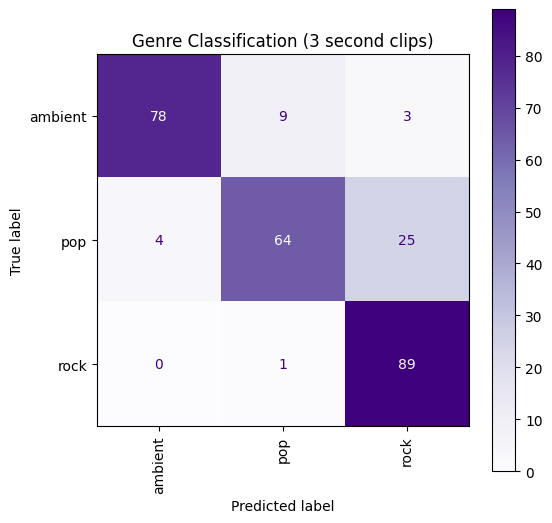

In [51]:
# Plot confusion matrix for review
genres = ['ambient', 'pop', 'rock']  # 3 classes
fig, ax = plt.subplots(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genres)
disp.plot(ax=ax, cmap = 'Purples', xticks_rotation='vertical')
plt.title('Genre Classification (3 second clips)');


In this notebook, 4 separate neural networks were trained:
1. Dense Neural Network (DNN)
2. Convolutional Neural Network (CNN)
3. Convolutional Neural Network with Regularization
4. Convolutional Neural Network with Regularization and Data Augmentation